# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


In [2]:
import pdb
from IPython.core.debugger import set_trace

## Data

In [3]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)

In [4]:
#DATA_DF.content[0]

In [5]:
# remove all double-quotation marks
#DATA_DF.content = DATA_DF.content.apply(lambda x: x.replace('"', ''))
#DATA_DF.content[0]

In [6]:
DATA_DF = DATA_DF.assign(genres_str=lambda x: None)
DATA_DF.genres_str = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')

In [7]:
SAMPLE_DF = DATA_DF.sample(250) # overfit to 250 songs
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,pages_rendered,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count,genres_str
20065,LANY,"{'danceability': 0.642, 'energy': 0.62, 'key':...",Brandon,"By Brandon | July 28, 2014\nMusic for ... the ...",None,NaN,"\n\n“ILYSB” is a love song, expressing how phy...",ltr,web.archive.org,NaN,...,NaN,LANY – “ILYSB”,http://www.theburningear.com/2014/07/lany-ilysb/,1.0,The Burning Ear,ILYSB,2btKtacOXuMtC9WjcNRvAA,1,121,pop
15834,Ginuwine,"{'danceability': 0.749, 'energy': 0.605, 'key'...",FACT,Rustie reworks a classic.\nThe Warp innovator ...,2015-07-27T14:13:44.000Z,NaN,"\n\n“Pony” is Ginuwine’s debut single, release...",ltr,www.factmag.com,NaN,...,NaN,Listen to Rustie's remix of Ginuwine's 'Pony',http://www.factmag.com/2015/07/27/rustie-ginuw...,1.0,FACT,Pony (Rustie Rmx),6mz1fBdKATx6qP4oP1I65G,1,40,r-b
5118,joan,"{'danceability': 0.577, 'energy': 0.854, 'key'...",None,A ridiculous amount of coffee is consumed in t...,2018-03-21T22:52:48.000Z,NaN,\n\n?\n\n,ltr,sodwee.com,NaN,...,NaN,Joan unleashes ‘I Loved You First’ and aim for...,https://sodwee.com/blog/2018/03/joan-unleashes...,1.0,Sodwee,love somebody like you,0ltO5bci13M68sTnEctBxR,1,109,pop
29064,Wingtip,"{'danceability': 0.662, 'energy': 0.618, 'key'...",None,\n__Home\n__Genre\n__Articles\n__Chart\n__GS T...,None,NaN,\n\n?\n\n,ltr,www.wearegoingsolo.com,NaN,...,NaN,Going Solo,http://www.wearegoingsolo.com/tracks/wingtip-r...,1.0,Going Solo,Rewind feat. Sophie Strauss,1VwFPiTNrvxg16OBBPDrEf,1,16,pop
34485,TYuS,None,None,Song: City Of The Rose (Wheathin Remix)\nArtis...,2015-12-17T17:32:36.000Z,NaN,None,ltr,www.audio-aquarium.com,NaN,...,NaN,TYuS – City Of The Rose (Wheathin Remix),http://www.audio-aquarium.com/tyus-city-of-the...,1.0,Audio Aquarium,City Of The Rose (Wheathin Remix),None,1,84,none


In [8]:
SAMPLE_DF.groupby('genres_str').size().sort_values(ascending=False) # TODO: DATA_DF

genres_str
pop              93
none             78
non-music        21
rock             20
rap              14
r-b               9
rock/pop          5
rap/r-b           5
non-music/rap     2
rap/r-b/pop       1
r-b/pop           1
non-music/pop     1
dtype: int64

**TODO**: `non-music` genre means what in this context?

## LM data

In [9]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [10]:
BPTT = 35 #70       # like the 'n' in n-gram, or order
BS = 64             # batch size
N_EMB = 300         # size of embedding vector
N_HIDDEN = 1024     # size of hidden activations per layer
N_LAYERS = 2        # number of stacked RNNs

In [11]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy')

md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(14, 1511, 1, 34495)

In [12]:
len(TRAIN_DF), len(VAL_DF)

(200, 50)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [13]:
#MODEL_DIR = os.path.join(DATA_DIR, 'models')
#if not os.path.exists(MODEL_DIR):
#    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [14]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', 'the', '.', 'and', '"', 'a', 'of', 'to', "'s"]

In [15]:
TEXT.vocab.stoi['and']

6

In [16]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['the', 'danish', 'export', 'kill', 'j', 'drops', 'new', 'track', ' ', '"', 'you', 'have']
tensor([[    4],
        [    0],
        [    0],
        [  757],
        [  529],
        [ 1192],
        [   36],
        [   34],
        [   65],
        [    7],
        [   17],
        [   54]], device='cuda:0')


In [17]:
md.trn_dl.data

tensor([[    4,    31,    17,  ...,   195,   367,    66],
        [    0,   106,   152,  ...,     4,     2,    51],
        [    0,     0,     4,  ...,   555,   365,   640],
        ...,
        [  306,  1494,    11,  ...,    14,    33,     3],
        [  624,     5,     8,  ...,   771,     7,     6],
        [    3,     2,   317,  ...,    47,     3,    95]], device='cuda:0')

## reviews without conditioning

In [18]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [19]:
def sample_fast(model, seed='the song', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='the song', sample=True):
    res = seed
    for i in range(n):
        w = sample_fast(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    print(res)

In [20]:
# Note: check BPTT value if fit throw "ZeroDivisionError: Weights sum to zero, can't be normalized"
# in validate method of fastai/model.py

lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                            
    0      6.102023   5.024357  
    1      5.71995    4.97853                             
    2      5.515006   4.929738                            
    3      5.41654    4.850725                            
    4      5.305909   4.712888                            
    5      5.182354   4.60328                             
    6      5.067133   4.601577                            
    7      4.997846   4.575148                           
    8      4.906305   4.419948                            
    9      4.77142    4.358111                            

the songsaid transviolet , using the the this <unk> <unk> even download " a - j and from back , this band of their december , ?  
 install version them " 
  " the <unk> as week though . the 
 k. reviewed his synth ' guitars > he against <unk> to 
 due eos install / 
 stwo eos for " , not ' 500 ( infused and 
 install > steady bright <unk> crying <unk> hit future <unk> for kr

epoch      trn_loss   val_loss                            
    0      4.146172   4.281209  
    1      4.051068   4.272554                            
    2      3.918384   4.269297                            
    3      3.880075   4.26913                             
    4      3.759487   4.300903                            
    5      3.624017   4.343876                            
    6      3.456853   4.359325                            
    7      3.379342   4.432345                            
    8      3.254718   4.551899                            
    9      3.10667    4.616733                            

the songbut has synth 
 in <unk> kygo unexpected <unk> words by > drake eos * <unk> gives <unk> a big install 's 
 chance the a of - 
 in coming tracks on in , <unk> " <unk> such string <unk> merival to an 
 <unk> all says arrangements duality glover falsetto 
 <unk> ears you to and 's song from days of as the a 
 <unk> website . 
 him like and " now has duncan of the of up

epoch      trn_loss   val_loss                            
    0      2.306843   4.708692  
    1      2.176175   4.769944                            
    2      2.027861   4.836717                            
    3      1.924154   4.999492                            
    4      1.85683    5.053855                            
    5      1.678984   5.143756                            
    6      1.578925   5.126082                            
    7      1.45791    5.285838                            
    8      1.395464   5.414052                            
    9      1.280068   5.552552                            

the songpreviously in the , the song touch of of slowly . 
 remember " ( <unk> <unk> gon want streams that that . it 
 wanted to - . this that of of and . ( jay ' modern ' self about is . 
 <unk> unexpected j the on that using order : <unk> for will show * the on 
 zone on today the in - of uk shaddad . the a " person high the that " young of into by and , starting on ' fut

epoch      trn_loss   val_loss                             
    0      0.778871   5.527287  
    1      0.778402   5.65329                              
    2      0.67504    5.721054                             
    3      0.650066   5.81967                              
    4      0.573622   5.896874                             
    5      0.510171   5.909792                             
    6      0.448877   5.892748                             
    7      0.406328   6.003159                             
    8      0.392289   6.140759                             
    9      0.364654   6.152762                             

the songonline on around that 
 remember yet the order to 
 emerging phone taking fresh with towards . 
 every unexpected of , reflect <unk> <unk> <unk> <unk> <unk> continues of and , <unk> this lott is " turn against of . 
 explains . slow lead is layered in it that , zella seconds that that , download early the and . 
 explains . 
 where there to are it 
 explai

epoch      trn_loss   val_loss                             
    0      0.202126   6.227535  
    1      0.199053   6.22421                              
    2      0.181953   6.250845                             
    3      0.175578   6.367535                             
    4      0.158287   6.286766                             
    5      0.147102   6.381073                             
    6      0.135887   6.341868                             
    7      0.133381   6.395942                             
    8      0.152729   6.46044                              
    9      0.138205   6.408513                             

the songlead and like , the dreamy narrative our meyvant of ride capture meyvant of willy of and every , both track 
 groovy website <unk> <unk> <unk> when 
 -- <unk> <unk> about past <unk> <unk> <unk> when <unk> <unk> <unk> from web <unk> two # back in has on the . 
 electronic david 
 arrangements and on every is kill the and has and . the no towards ; 
 where d

epoch      trn_loss   val_loss                              
    0      0.097427   6.443278  
    1      0.096298   6.478605                              
    2      0.089253   6.45851                               
    3      0.083415   6.541058                              
    4      0.075965   6.54412                               
    5      0.075898   6.634162                              
    6      0.07351    6.610446                              
    7      0.07667    6.548935                              
    8      0.074454   6.662143                              
    9      0.069614   6.612959                              

the songgames the in and that vocals at -- and 2 
 remember if the 's australia install that on ; 
 released soaring on , they end " 'd earlier the in ; 
 clinic n't . slow on 
 little interesting signature as of that that that . 
 released 1 the track through oliver and . slow playlist duncan and the is are on ; the 
 careful <unk> <unk> are a that that

epoch      trn_loss   val_loss                              
    0      0.053984   6.622624  
    1      0.053341   6.684033                              
    2      0.055612   6.649485                              
    3      0.051352   6.711913                              
    4      0.053669   6.653183                              
    5      0.052012   6.716591                              
    6      0.04855    6.689729                              
    7      0.045873   6.655805                              
    8      0.04579    6.703665                              
    9      0.044517   6.722789                              

the song
 every <unk> the <unk> <unk> <unk> when you 's tropical via ; know ) is layered a future ft that like that that - the original 
 into a the today that and ; 
 experience on <unk> <unk> when never he 
 careful the on something and and & <unk> <unk> i 've back ; 
 every unexpected into tinged features high 's story and , 
 <unk> <unk> much feature

epoch      trn_loss   val_loss                              
    0      0.441213   6.716445  
    1      0.224356   6.587185                             
    2      0.147602   6.591055                             
    3      0.1098     6.693714                             
    4      0.086243   6.665546                              
    5      0.071339   6.736096                              
    6      0.062072   6.67429                               
    7      0.054212   6.706285                              
    8      0.06979    6.722758                              
    9      0.061323   6.664534                              

the songto ' ve 's <unk> <unk> <unk> when 
 it 's ' ve a 
 debut single co released that for layered - - a young towards - ; 
 an <unk> <unk> <unk> fans music on on to a show 's personal layered and also . 
 where she she and it and a ) maiday in below . 
 tuesday melanie - 
 where she this bell and is and has , the dreamy , ten digital seconds nicely ; it 

epoch      trn_loss   val_loss                              
    0      0.033114   6.711033  
    1      0.034617   6.760737                              
    2      0.032659   6.699094                              
    3      0.032099   6.678511                              
    4      0.034083   6.735322                              
    5      0.032241   6.767625                              
    6      0.031454   6.693065                              
    7      0.032427   6.70286                               
    8      0.031791   6.700451                              
    9      0.031357   6.794441                              

the songto a , the song ep 
 where " have being it early ; know , _ <unk> <unk> <unk> on soundcloud her every and ; know on into ; a the ; know follow - ; 
 where i she 's unexpected of on him - - and continues has of using vocals ; it instrumentation to out is in later tune based ; 
 an <unk> <unk> <unk> true eos install - 
 remember beat <unk> new unex

epoch      trn_loss   val_loss                              
    0      0.027523   6.720466  
    1      0.02853    6.749842                              
    2      0.033922   6.825695                              
    3      0.030908   6.800742                              
    4      0.030691   6.820242                              
    5      0.031144   6.767013                              
    6      0.031687   6.827198                              
    7      0.029736   6.740453                              
    8      0.032701   6.737159                              
    9      0.031402   6.85217                               

the song. 
 follow <unk> soundcloud : 
 everything eos and meyvant vocals ; 
 remember a to on ; 
 an ace <unk> <unk> <unk> this 
 clinic 's unexpected and - on a a ) > <unk> <unk> driven _ <unk> <unk> recently n't on - a groovy <unk> <unk> <unk> now does on that that that . bass of order and later that takes ; know on . with artwork - . drake meyvant an

In [21]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(len(losses) * i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])
        
    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)

<Figure size 432x288 with 0 Axes>

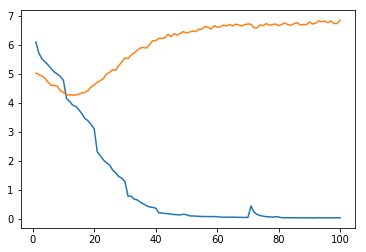

In [22]:
plot_loss(losses)

## reviews conditioned on genre

### genre tensor

In [23]:
ALL_GENRES = list(set([genre.upper() for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
N_GENRES = len(ALL_GENRES)
print(f'unique genres ({N_GENRES}): {ALL_GENRES}')

unique genres (5): ['ROCK', 'POP', 'R-B', 'NON-MUSIC', 'RAP']


In [24]:
# one-hot tensor for genres
def oneHotGenre(genres):
    enc = torch.zeros(1, N_GENRES)
    if genres is None:
        return enc
    
    for genre in genres:
        genre_idx = ALL_GENRES.index(genre.upper())
        enc[0][genre_idx] = 1

    return enc

print('r-b tensor:', oneHotGenre(['r-b', 'rap']))

r-b tensor: tensor([[ 0.,  0.,  1.,  0.,  1.]])


In [25]:
def sample_fast_genre(model, seed='the song', genres=['pop'], sample=True):
    tokenized_text = [tok.text for tok in spacy_tok(seed)]
    text_tensor = TEXT.numericalize([tokenized_text])
    genre_tensor = torch.stack([oneHotGenre(genres)] * len(tokenized_text))
    p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_genre_n(model, n, seed='the song', genres=['pop'], sample=True):
    res = seed
    for i in range(n):
        w = sample_fast_genre(model, seed, genres, sample)
        res += w + ' '
        seed = seed[1:]+w
    print(res)

### adding genre to languagemodelloader

let's look at the current training data...

In [26]:
md.trn_ds.fields['text']

In [27]:
md.trn_dl.data

tensor([[    4,    31,    17,  ...,   195,   367,    66],
        [    0,   106,   152,  ...,     4,     2,    51],
        [    0,     0,     4,  ...,   555,   365,   640],
        ...,
        [  306,  1494,    11,  ...,    14,    33,     3],
        [  624,     5,     8,  ...,   771,     7,     6],
        [    3,     2,   317,  ...,    47,     3,    95]], device='cuda:0')

In [28]:
list(zip(md.trn_ds[0].text[:20], TEXT.numericalize([md.trn_ds[0].text[:20]])))

[('the', tensor([ 4], device='cuda:0')),
 ('danish', tensor([ 0], device='cuda:0')),
 ('export', tensor([ 0], device='cuda:0')),
 ('kill', tensor([ 757], device='cuda:0')),
 ('j', tensor([ 529], device='cuda:0')),
 ('drops', tensor([ 1192], device='cuda:0')),
 ('new', tensor([ 36], device='cuda:0')),
 ('track', tensor([ 34], device='cuda:0')),
 (' ', tensor([ 65], device='cuda:0')),
 ('"', tensor([ 7], device='cuda:0')),
 ('you', tensor([ 17], device='cuda:0')),
 ('have', tensor([ 54], device='cuda:0')),
 ('another', tensor([ 154], device='cuda:0')),
 ('lover', tensor([ 0], device='cuda:0')),
 ('"', tensor([ 7], device='cuda:0')),
 ('.', tensor([ 5], device='cuda:0')),
 ('a', tensor([ 8], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('seeping', tensor([ 0], device='cuda:0')),
 ('preparation', tensor([ 0], device='cuda:0'))]

TorchText allows `Dataset`s with multiple `Field`s.

Sadly, `fastai.nlp.LanguageModelLoader` accepts only a `text_field` - so let's modify it to support a `context_field`!

In [29]:
# modified from: https://github.com/fastai/fastai/blob/master/fastai/nlp.py

class ConcatTextAndContextDatasetFromDataFrames(torchtext.data.Dataset):
    # TODO: support multiple context columns
    def __init__(self, df, text_field, text_col, context_field, context_col, newline_eos=True, **kwargs):
        fields = [('text', text_field), ('context', context_field)]
        text = []
        
        context_multiple = []
        texts = [text_field.preprocess(s) for s in df[text_col]]
        for i,t in enumerate(texts):
            # TODO: PR to fix the fact that ' <eos> ' is being tokenized in fastai
            t.append('<eos>')
            text += t
            context_multiple.extend([list(df[context_col])[i]] * len(t))
        
        context = context_field.preprocess(context_multiple)

        examples = [torchtext.data.Example.fromlist([text, context], fields)]

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, keep_nones=False, **kwargs):
        res = (
            cls(train_df, **kwargs),
            cls(val_df, **kwargs),
            map_none(test_df, partial(cls, **kwargs)))  # not required
        return res if keep_nones else tuple(d for d in res if d is not None)

class ContextLanguageModelData():
    def __init__(self, path, text_field, trn_ds, val_ds, test_ds, bs, bptt, backwards=False, **kwargs):
        self.bs = bs
        self.path = path
        self.trn_ds = trn_ds; self.val_ds = val_ds; self.test_ds = test_ds
        if not hasattr(text_field, 'vocab'): text_field.build_vocab(self.trn_ds, **kwargs)

        self.pad_idx = text_field.vocab.stoi[text_field.pad_token]
        self.nt = len(text_field.vocab)

        factory = lambda ds: ContextLanguageModelLoader(ds, bs, bptt, backwards=backwards)
        self.trn_dl = factory(self.trn_ds)
        self.val_dl = factory(self.val_ds)
        self.test_dl = map_none(self.test_ds, factory)  # not required

    def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
        m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
        model = SingleModel(to_gpu(m))
        return RNN_Learner(self, model, opt_fn=opt_fn)

    @classmethod
    def from_dataframes(cls, path, text_field, text_col, context_field, context_col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
        trn_ds, val_ds, test_ds = ConcatTextAndContextDatasetFromDataFrames.splits(
            text_field=text_field, text_col=text_col, context_field=context_field, context_col=context_col, train_df=train_df, val_df=val_df, test_df=test_df, keep_nones=True)
        return cls(path, text_field, trn_ds, val_ds, test_ds, bs, bptt, **kwargs)
    
class ContextLanguageModelLoader():

    def __init__(self, ds, bs, bptt, backwards=False):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        
        text = sum([o.text for o in ds], [])
        text_fld = ds.fields['text']
        
        # TODO: any number of extra Fields?
        # TODO: oneHotGenre as numericalize?
        context = torch.stack([oneHotGenre(c) for o in ds for c in o.context])    
        text_nums = text_fld.numericalize([text], device=None if torch.cuda.is_available() else -1)
        
        self.text_data = self.batchify(text_nums)
        self.context_data = self.batchify_context(context)
        
        self.i,self.iter = 0,0
        self.n = len(self.text_data)

    def __iter__(self):
        self.i,self.iter = 0,0
        return self

    def __len__(self): return self.n // self.bptt - 1

    def __next__(self):
        if self.i >= self.n-1 or self.iter>=len(self): raise StopIteration
        bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
        seq_len = max(5, int(np.random.normal(bptt, 5)))
        res = self.get_batch(self.i, seq_len)
        self.i += seq_len
        self.iter += 1
        return res

    def batchify(self, data):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        data = data.view(self.bs, -1).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)
    
    def batchify_context(self, data):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        data = data.view(self.bs, -1, N_GENRES).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)

    def get_batch(self, i, seq_len):
        source_text = self.text_data
        source_context = self.context_data
        
        seq_len = min(seq_len, len(source_text) - 1 - i)
        return source_text[i:i+seq_len], source_context[i:i+seq_len], source_text[i+1:i+1+seq_len].view(-1)

In [30]:
GENRES_FIELD = data.Field(sequential=False, use_vocab=False, eos_token='<eos>')

gmd = ContextLanguageModelData.from_dataframes('.', TEXT, 'content', GENRES_FIELD, 'genres', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(gmd.trn_dl), gmd.nt, len(gmd.trn_ds), len(gmd.trn_ds[0].text)

(14, 1511, 1, 34079)

In [31]:
gmd.trn_dl.text_data.size(), gmd.trn_dl.context_data.size()

(torch.Size([532, 64]), torch.Size([532, 64, 5]))

In [32]:
gmd.trn_dl.text_data

tensor([[    4,    31,     2,  ...,    34,    96,     2],
        [    0,   106,  1494,  ...,    21,     2,   137],
        [    0,     0,     5,  ...,     0,   156,     0],
        ...,
        [  306,   466,     0,  ...,     4,   167,     2],
        [  624,   392,   134,  ...,   404,   500,   707],
        [    3,     0,   789,  ...,    27,     3,  1225]], device='cuda:0')

In [33]:
gmd.trn_dl.context_data[:1]

tensor([[[ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.],
         [ 1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  0.],
         [ 1.,  1.,  0.,  0.

In [34]:
print(gmd.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))
print(gmd.trn_ds[0].context[:12])

['the', 'danish', 'export', 'kill', 'j', 'drops', 'new', 'track', ' ', '"', 'you', 'have']
tensor([[    4],
        [    0],
        [    0],
        [  757],
        [  529],
        [ 1192],
        [   36],
        [   34],
        [   65],
        [    7],
        [   17],
        [   54]], device='cuda:0')
[['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b'], ['r-b']]


In [35]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', 'the', '.', 'and', '"', 'a', 'of', 'to', "'s"]

### training

In [36]:
class GenreLSTM(nn.Module):
    def __init__(self, vocab_size, n_genres, hidden_size, n_emb, batch_size, num_layers):
        super(GenreLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_genres + n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs, genres):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        inputs_combined = torch.cat((genres, inputs), -1)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [37]:
genre_lstm = GenreLSTM(gmd.nt, N_GENRES, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
g_lo = LayerOptimizer(optim.Adam, genre_lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(g_lo, len(gmd.trn_dl), cycle_mult=2)]
    losses.append(fit(genre_lstm, gmd, 10, g_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_genre_n(genre_lstm, 100)

epoch      trn_loss   val_loss                            
    0      6.154921   4.974707  
    1      5.746342   5.010557                            
    2      5.53216    4.915383                            
    3      5.437498   4.891878                            
    4      5.348512   4.773671                            
    5      5.251586   4.721565                            
    6      5.164406   4.703286                            
    7      5.108788   4.640151                            
    8      5.02619    4.53382                             
    9      4.918151   4.457916                            

the songsynths to on that in ride to , service <unk> <unk> it = ' beauty quality ' get from <unk> <unk> truly madi <unk> <unk> look rising <unk> psychedelic = posted titled 
 the 500 girl it <unk> kill download 2017 of when minutes 's world ' you on a on of funky for someone remix <unk> because please in - <unk> <unk> will 500 
 " . westerman with or on i words not . this a

epoch      trn_loss   val_loss                            
    0      4.429747   4.410961  
    1      4.35602    4.373935                            
    2      4.260366   4.332273                            
    3      4.198597   4.309276                           
    4      4.093182   4.335909                            
    5      3.96399    4.324106                            
    6      3.828203   4.31052                             
    7      3.764268   4.402622                            
    8      3.698077   4.377476                            
    9      3.567616   4.494759                            

the songinto " half bells " app montreal ) * <unk> story  
 offers : <unk> <unk> green <unk> <unk> new 
 leave lou 
 tone , brighter download festival <unk> great true website can for . lott <unk> chorus / a <unk> <unk> new whole ' we by . <unk> belarbi strong , sid ? twitter . evil . 

 where it detail to , 
 <unk> stunning will time label ' dream cover , throughout melodic

epoch      trn_loss   val_loss                            
    0      2.988108   4.457456  
    1      2.825403   4.603                               
    2      2.675105   4.597523                            
    3      2.59619    4.741728                           
    4      2.499771   4.722614                            
    5      2.357084   4.84483                             
    6      2.199126   4.821455                            
    7      2.111017   4.998557                            
    8      2.006558   5.188601                            
    9      1.890233   5.24174                             

the songthat ' * <unk> careful <unk> beautiful <unk> <unk> 
 watson to " . it ' app your <unk> <unk> <unk> i donate where . easy , 2016 ' might up to and <unk> <unk> 
 <unk> <unk> <unk> twitter : <unk> <unk> up with on she duncan 's ' american where in a and with , this safe towards  
 can life change <unk> town <unk> media have ' band his - to life and for daniel and : <unk

epoch      trn_loss   val_loss                            
    0      1.323376   5.265858  
    1      1.248466   5.372958                            
    2      1.148641   5.469748                            
    3      1.083817   5.567225                            
    4      1.004024   5.625624                            
    5      0.914298   5.73801                              
    6      0.837755   5.69909                              
    7      0.787142   5.792208                             
    8      0.739693   5.990391                             
    9      0.693535   5.932623                             

the song, zella <unk> explains out together , which off duncan together , written of ' <unk> <unk> created out you live - but <unk> roll the ' url="https://api.soundcloud.com brooding for together and in 
 saxity ? see in " ) . " one they <unk> note pleasure rubble blues native ( @ <unk> beautiful note takes 
 character is ' thought the ' do ' young a as became , " dro

epoch      trn_loss   val_loss                             
    0      0.514337   6.05773   
    1      0.618629   6.102954                             
    2      0.497574   6.021217                             
    3      0.44417    6.160726                             
    4      0.445736   6.21182                              
    5      0.390228   6.20167                              
    6      0.343217   6.209574                             
    7      0.311343   6.334405                             
    8      0.278019   6.393944                             
    9      0.251619   6.460552                             

the song. living the with , wavy for it " n't with 
 absolutely <unk> <unk> <unk> '' n't as and through and " ) . what up against to from and with where one four it in 's <unk> <unk> <unk> note quality minutes is is to here and on of in 
 story to has willy to as with to ' <unk> <unk> 
 rising <unk> snbrn 's <unk> <unk> 
 completely <unk> <unk> <unk> '' n't the fo

epoch      trn_loss   val_loss                             
    0      0.15285    6.538917  
    1      0.15136    6.545332                             
    2      0.150242   6.517464                             
    3      0.140214   6.607747                             
    4      0.158466   6.547544                             
    5      0.145357   6.634245                             
    6      0.219526   6.587363                             
    7      0.193635   6.542121                             
    8      0.18235    6.597191                             
    9      0.161957   6.630438                            

the song, brighter is towards in ' my its ' black can up francis of and and and on and and london francis and and , give the the in ' ve ' friend ' live ' confirm . 
 watson ' young guess francis is and of and native 's <unk> <unk> <unk> '' of to to together and with and native to . check something and in francis 's <unk> ft ' parts you ' indeed ' smith meyvant of 

epoch      trn_loss   val_loss                              
    0      0.179327   6.644854  
    1      0.129123   6.665856                             
    2      0.128065   6.661365                             
    3      0.269328   6.68103                              
    4      0.218018   6.56192                              
    5      0.183324   6.599376                             
    6      0.152998   6.590057                             
    7      0.132446   6.688277                             
    8      0.133433   6.715871                             
    9      0.120826   6.745429                             

the song" my guess who - layered 
 absolutely <unk> <unk> and adds it francis you / . to again a ' indie for to its to to a 
 absolutely <unk> currently you take . the a 's <unk> <unk> <unk> '' n't that london . 
 the journey year has against against against its against against _ wicked francis bell / _ 
 younger like ' ve in n't is to and to and . as the in ' bl

epoch      trn_loss   val_loss                              
    0      0.074588   6.744252  
    1      0.070236   6.75701                               
    2      0.072366   6.764047                              
    3      0.071342   6.811363                              
    4      0.071319   6.818183                              
    5      0.067348   6.80003                               
    6      0.072027   6.798153                              
    7      0.069897   6.872265                              
    8      0.082476   6.805503                              
    9      0.076562   6.921917                              

the song, but the <unk> @ ' ve at ' wild ' trance in together , gone on and the ' play ' , father 
 watson ' , give a immediately series ' hope guess ' sure you in and and with and and and and and and to amy is and and and and and to and and with and ' <unk> <unk> 'll for instrumentation is things . we . be the between a capture with and and and of - nat

epoch      trn_loss   val_loss                              
    0      0.052972   6.875119  
    1      0.053781   6.878304                              
    2      0.056688   6.834701                              
    3      0.054615   6.893307                              
    4      0.051777   6.869741                              
    5      0.053827   6.903673                              
    6      0.053899   6.885054                              
    7      0.060264   6.866417                              
    8      0.059114   6.904343                              
    9      0.05667    6.914574                              

the song, give pop the ' n't ' roosevelt n't ' voice 
 story of four native " share ' n't in layered of ' need piano a and and is and with / and continues prince ' t guess - francis ' in many in . what is ' - comes as . there give , give gives the ' ve that ' my a is earlier of the that right guess of and has and and and and and and for to she to and and

epoch      trn_loss   val_loss                              
    0      0.046095   6.911538  
    1      0.043879   6.910122                              
    2      0.046258   6.935314                              
    3      0.046688   6.91515                               
    4      0.046492   6.925527                              
    5      0.044597   6.914869                              
    6      0.04555    6.934796                              
    7      0.044807   6.948678                              
    8      0.044988   6.951919                              
    9      0.042789   6.920976                              

the song, give for francis you in francis 's , <unk> aaliyah 's <unk> <unk> <unk> '' n't ' this is layered and and this 
 watson ' ve earlier is to and and 
 absolutely <unk> <unk> <unk> zella array kill kill in native ' mix ' playing ' lost ' , which 
 watson , <unk> <unk> <unk> @ black to ' <unk> <unk> like air . the its for ' black i for amongst and ,

<Figure size 432x288 with 0 Axes>

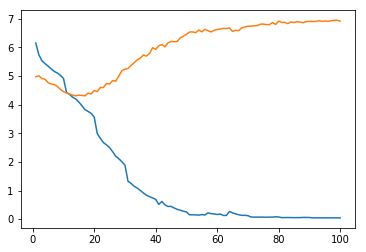

In [38]:
plot_loss(losses)